<a href="https://colab.research.google.com/github/SharatGupta/DSML-Projects/blob/main/Zee_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

110697-zee.avif

## Business Problem & Required Outcome

* Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience
* The focus is on leveraging user ratings and similarities among users to create a
robust, personalized movie recommender system.
* Utilizing a comprehensive dataset of movie ratings, user demographics, and
movie details, Develop a system that can accurately predict user
preferences and suggest movies accordingly.
* The insights gained from this system are expected to drive user engagement,
increase satisfaction, and foster a more intuitive user experience.

# Importing Libraries

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import re

!pip install category_encoders
from category_encoders import TargetEncoder
# !pip install sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler

from scipy.stats import pearsonr

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.neighbors import NearestNeighbors

!pip install cmfrec
from cmfrec import CMF

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape)

from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
!pip install umap-learn
!pip install umap-learn[plot]
import umap
import umap.plot

# Loading Data & Checking Structures

In [286]:
#!pip install gdown

In [287]:
!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 95.9MB/s]


In [288]:
!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 176MB/s]


In [289]:
!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 62.2MB/s]


In [536]:
movies=pd.read_fwf("zee-movies.dat",encoding='ISO-8859-1')

In [291]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [292]:
movies.shape

(3883, 3)

In [537]:
movies.head(5)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [294]:
ratings=pd.read_fwf("zee-ratings.dat",encoding='ISO-8859-1')

In [295]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [296]:
ratings.shape

(1000209, 1)

In [297]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [298]:
users=pd.read_fwf("zee-users.dat",encoding='ISO-8859-1')

In [299]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


In [300]:
users.shape

(6040, 1)

In [301]:
users.head(5)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


# Extracting Features from each Dataset

## Movies

In [302]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


Let drop the Columns with Incompletely Filled Data

In [540]:
a= movies["Unnamed: 1"].isnotnull() & movies["Unnamed: 2"].isnotnull()
a.sum()

3783

In [541]:
B = movies[~a]

In [543]:
B["Movie ID"] = B["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[0])
B["Title"] = B["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[1])
B["Genres"] = B["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[-1])

In [308]:
movies = movies[movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()]

In [309]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3783 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3783 non-null   object
 1   Unnamed: 1               0 non-null      object
 2   Unnamed: 2               0 non-null      object
dtypes: object(3)
memory usage: 118.2+ KB


In [310]:
movies.drop(columns = ["Unnamed: 1","Unnamed: 2"], inplace=True)

In [311]:
movies.shape

(3783, 1)

In [312]:
movies.head(5)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


* Lets Extract Features

In [313]:
movies.shape

(3783, 1)

In [314]:
movies["Movie ID"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[0])
movies["Title"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[1])
movies["Genres"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[-1])

In [315]:
movies.head()

,Movie ID::Title::Genres,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance,3,Grumpier Old Men (1995),Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama,4,Waiting to Exhale (1995),Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy,5,Father of the Bride Part II (1995),Comedy


In [316]:
movies["Genressplit"] = movies["Genres"].str.split("|")

In [317]:
movies = movies.explode("Genressplit")

In [318]:
movies.drop(columns= ["Movie ID::Title::Genres"], inplace = True)

In [320]:
movies.head()

,Movie ID,Title,Genres,Genressplit
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's


 * Lets Extract Release Year Features also

In [321]:
movies["Releaseyear"] = movies["Title"].str.split("(").transform(lambda x : x[-1])

In [322]:
movies["Releaseyear"] = movies["Releaseyear"].str.split(")").transform(lambda x : x[0])

In [323]:
movies["Releaseyear"].value_counts()

1998    556
1996    527
1997    526
1995    525
1999    417
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: Releaseyear, Length: 81, dtype: int64

In [324]:
movies["Genres"]=movies["Genres"].astype("category")
movies["Releaseyear"]=movies["Releaseyear"].astype("int")

In [325]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Movie ID     6174 non-null   object  
 1   Title        6174 non-null   object  
 2   Genres       6174 non-null   category
 3   Genressplit  6174 non-null   object  
 4   Releaseyear  6174 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 263.6+ KB


## Users

In [326]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [327]:
users["USerID"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[0])
users["Gender"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[1])
users["Age"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[2])
users["Occupation"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[3])
users["Zipcode"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[4])

In [328]:
users.drop(columns= ["UserID::Gender::Age::Occupation::Zip-code"], inplace = True)

In [329]:
users["Gender"]=users["Gender"].astype("category")
users["Occupation"]=users["Occupation"].astype("category")
users["Age"]=users["Age"].astype("category")
users["Zipcode"]=users["Zipcode"].astype("category")

In [330]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [331]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Ratings

In [332]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [333]:
ratings["USerID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[0])
ratings["Movie ID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[1])
ratings["Rating"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[2])
ratings["Timestamp"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[3])

In [334]:
ratings.drop(columns= ["UserID::MovieID::Rating::Timestamp"], inplace = True)

In [335]:
ratings["Rating"]=ratings["Rating"].astype("int")
ratings["Timestamp"]=ratings["Timestamp"].astype("int")

In [337]:
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [338]:
ratings['dayofweek'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())

In [339]:
ratings['month'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).month)
ratings['year'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).year)

In [340]:
ratings['day'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).day)

In [341]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [342]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


# Exploratory Data Analysis

## Movies

In [343]:
movies.head()

,Movie ID,Title,Genres,Genressplit,Releaseyear
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,1995
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's,1995
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's,1995


In [344]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 296
No of Unique Genressplit are 25
No of Unique Releaseyear are 81


In [345]:
movies["Genressplit"].value_counts().reset_index()

,index,Genressplit
0,Drama,1568
1,Comedy,1170
2,Action,485
3,Thriller,484
4,Romance,452
5,Horror,332
6,Adventure,257
7,Sci-Fi,255
8,Children's,227
9,Crime,208


* Some of the Genres are not completely spelled, we will correct them so that they do no behave as separate Genre

In [346]:
movies.loc[movies["Genressplit"] =="Horro","Genressplit"] = "Horror"
movies.loc[movies["Genressplit"] =="Fantas","Genressplit"] = "Fantasy"
movies.loc[movies["Genressplit"] =="Dram","Genressplit"] = "Drama"
movies.loc[movies["Genressplit"] =="Wester","Genressplit"] = "Western"
movies.loc[movies["Genressplit"] =="Sci-F","Genressplit"] = "Sci-Fi"
movies.loc[movies["Genressplit"] =="Thrille","Genressplit"] = "Thriller"
movies.loc[movies["Genressplit"] =="Wa","Genressplit"] = "War"

In [347]:
movies["Genressplit"].nunique()

18

<Axes: xlabel='Genressplit', ylabel='count'>

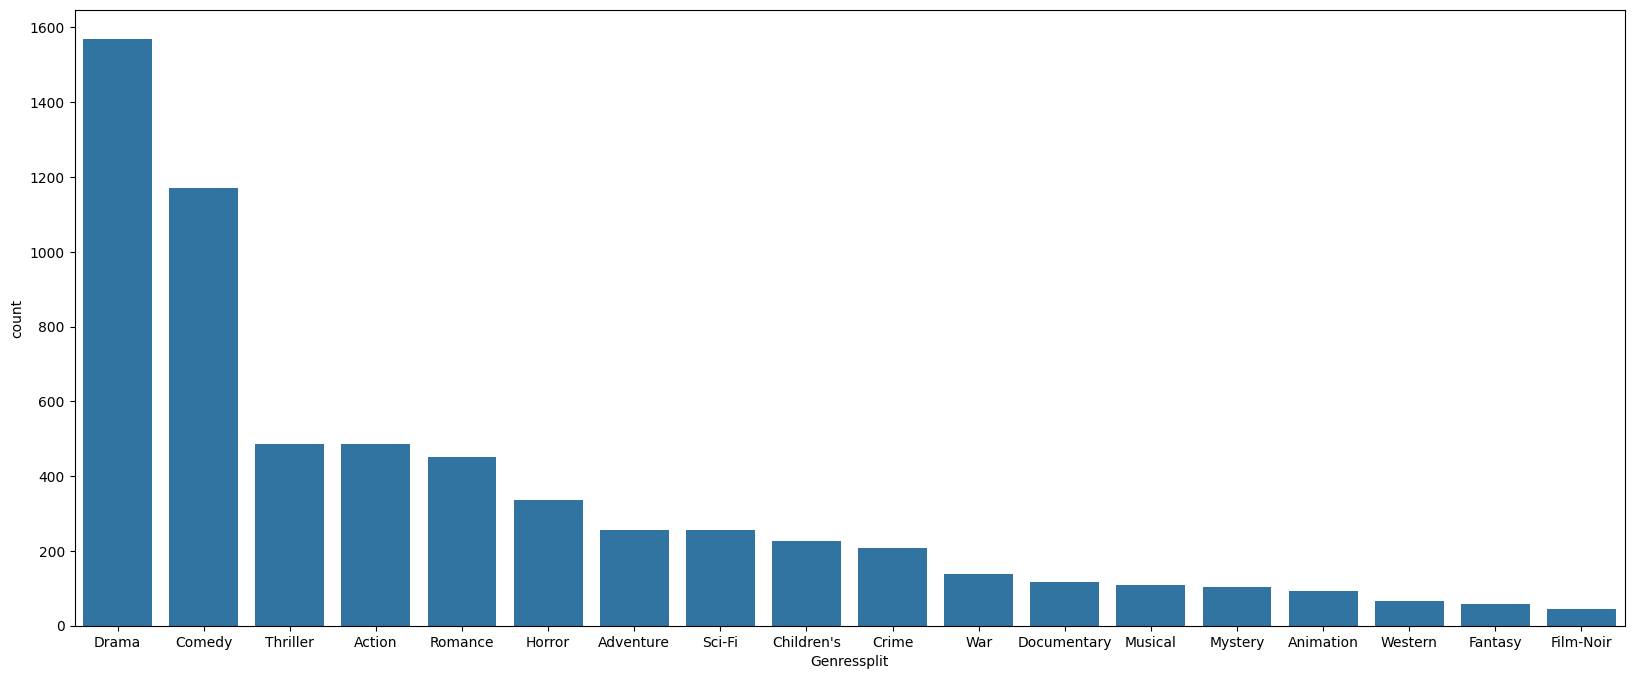

In [348]:
plt.figure(figsize =(20,8))
sns.countplot(data= movies, x="Genressplit", order = movies["Genressplit"].value_counts().reset_index()["index"])

* There is content avaiable in 18 Genres
* Most of the Movies  are in the Genres
1. Drama
2. Comedy
3. Thriller & Action


In [349]:
movies.Releaseyear.describe()

count    6174.000000
mean     1986.229997
std        16.547598
min      1919.000000
25%      1983.000000
50%      1994.000000
75%      1997.000000
max      2000.000000
Name: Releaseyear, dtype: float64

<Axes: xlabel='Releaseyear', ylabel='Count'>

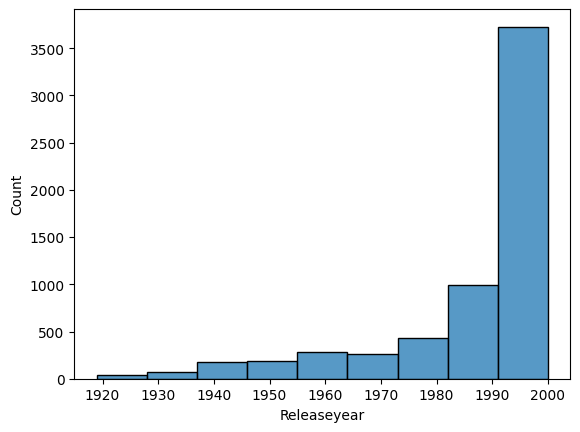

In [350]:
sns.histplot(data=movies, x= "Releaseyear", bins =9)

* More than 75% of the movies have release year after 1983

* lets Convert Release year into bins as Release year recency factor

In [351]:
bins = [1919,1940,1960,1980,1990,2000]
movies["Releaseyeargroups"] = pd.cut(movies["Releaseyear"], bins, labels=[1,2,3,4,5])

<Axes: xlabel='count', ylabel='Releaseyeargroups'>

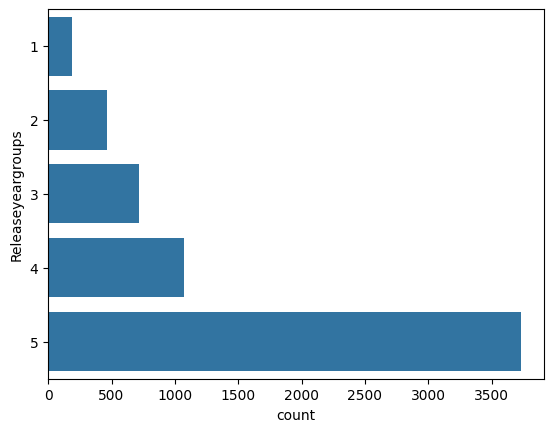

In [352]:
sns.countplot( movies["Releaseyeargroups"])

In [353]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3783
No of Unique Genres are 296
No of Unique Genressplit are 18
No of Unique Releaseyear are 81
No of Unique Releaseyeargroups are 5


## Users

In [354]:
for i in users.columns:
  print("No of Unique {} are {}".format(i,users[i].nunique()))

No of Unique USerID are 6040
No of Unique Gender are 2
No of Unique Age are 7
No of Unique Occupation are 21
No of Unique Zipcode are 3439


In [355]:
users.shape

(6040, 5)

In [356]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [357]:
Occup = {0: "other",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

In [358]:
users["Occupation"].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

* Majority of the Users occupation
1. college/grad student
2. executive/managerial
3. academic/educator

* Minimum no of users are from below Occupations
1. Farmers
2. tradesman/craftsman
3. homemakers

<Axes: xlabel='index', ylabel='Occupation'>

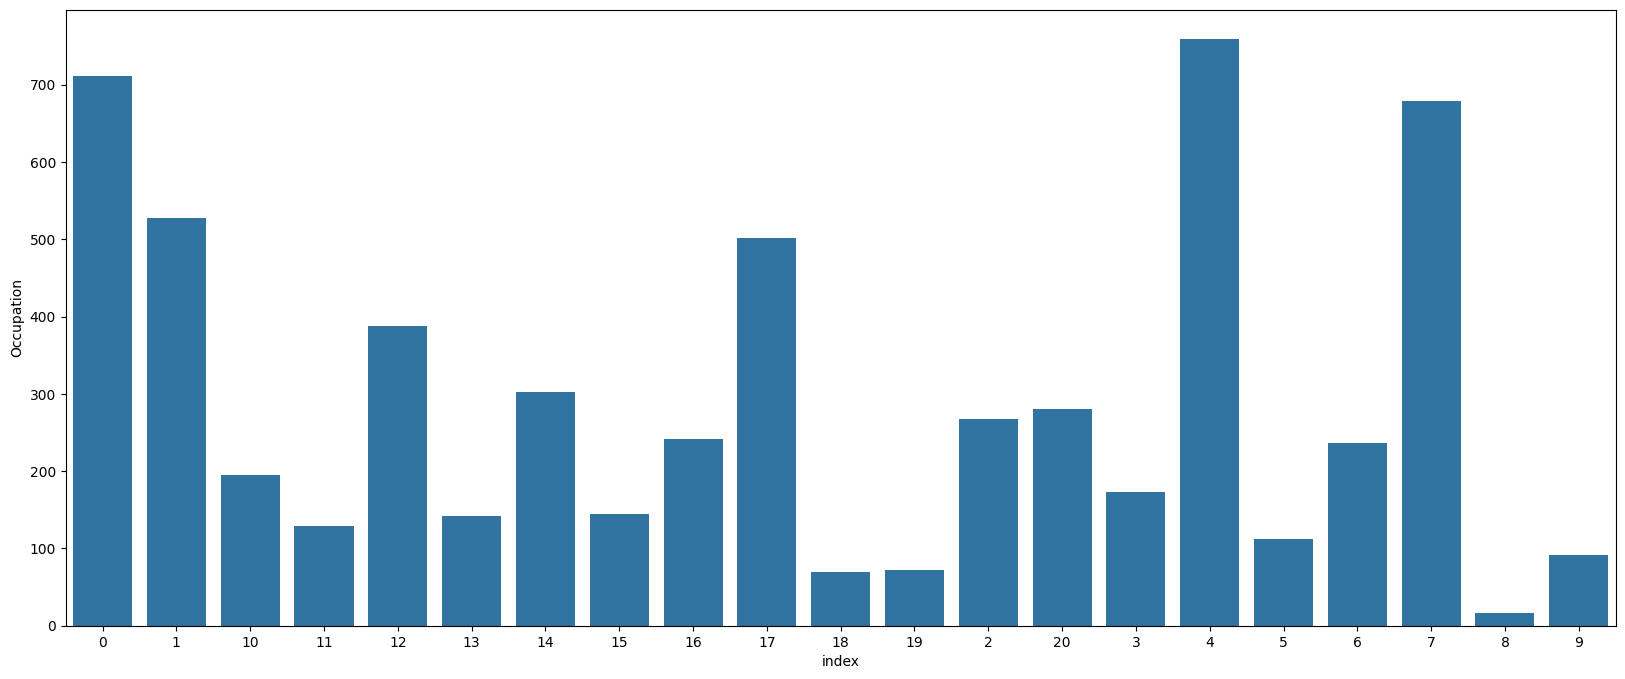

In [359]:
plt.figure(figsize =(20,8))
sns.barplot(data= users["Occupation"].value_counts().reset_index(), x= "index", y="Occupation")

In [360]:
users["Age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: Age, dtype: int64

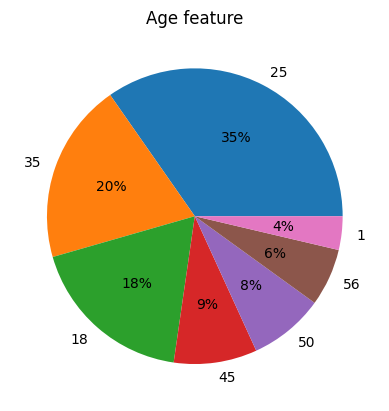

In [361]:
plt.pie(x = users["Age"].value_counts().reset_index()["Age"],
        labels = users["Age"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Age feature")
plt.show()

* 35% of the users are in the Age group "25 ~ 34"
* 20% of the users are in the Age group "35 ~ 44"
* only 4 % of the users are from age group "1~17"
* only 6% fo the users are from group >56

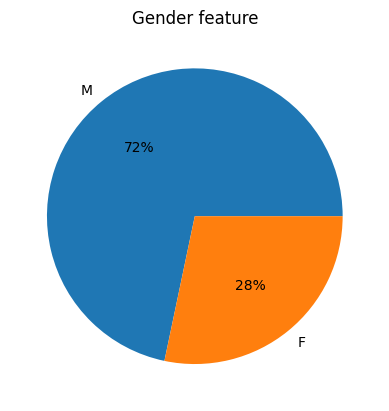

In [362]:
plt.pie(x = users["Gender"].value_counts().reset_index()["Gender"],
        labels = users["Gender"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Gender feature")
plt.show()

* 72% users are Male Gender only 28% are Female Gender

In [363]:
users["Zipcode"].value_counts().head(5)

48104    19
22903    18
94110    17
55104    17
10025    16
Name: Zipcode, dtype: int64

In [364]:
users["Zipcode"].value_counts().tail(5)

37843    1
37877    1
37909    1
37914    1
99945    1
Name: Zipcode, dtype: int64

## Ratings

In [365]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


In [366]:
for i in ratings.columns:
  print("No of Unique {} are {}".format(i,ratings[i].nunique()))

No of Unique USerID are 6040
No of Unique Movie ID are 3706
No of Unique Rating are 5
No of Unique Timestamp are 458455
No of Unique hour are 24
No of Unique dayofweek are 7
No of Unique month are 12
No of Unique year are 4
No of Unique day are 31


* Out of all 3783 Movies, Rating are avaiable for only 3706

In [367]:
ratings.shape

(1000209, 9)

In [368]:
ratings["Rating"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

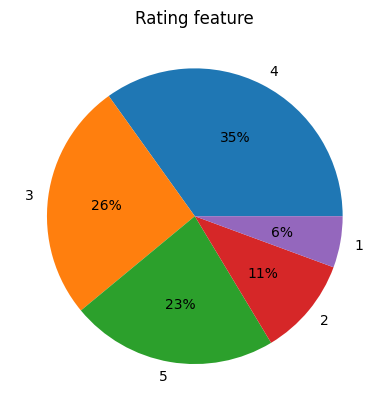

In [369]:
plt.pie(x = ratings["Rating"].value_counts().reset_index()["Rating"],
        labels = ratings["Rating"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("Rating feature")
plt.show()

* 35% of the ratings are given as 4
* only 23% of ratings are given as 5

<Axes: xlabel='hour', ylabel='count'>

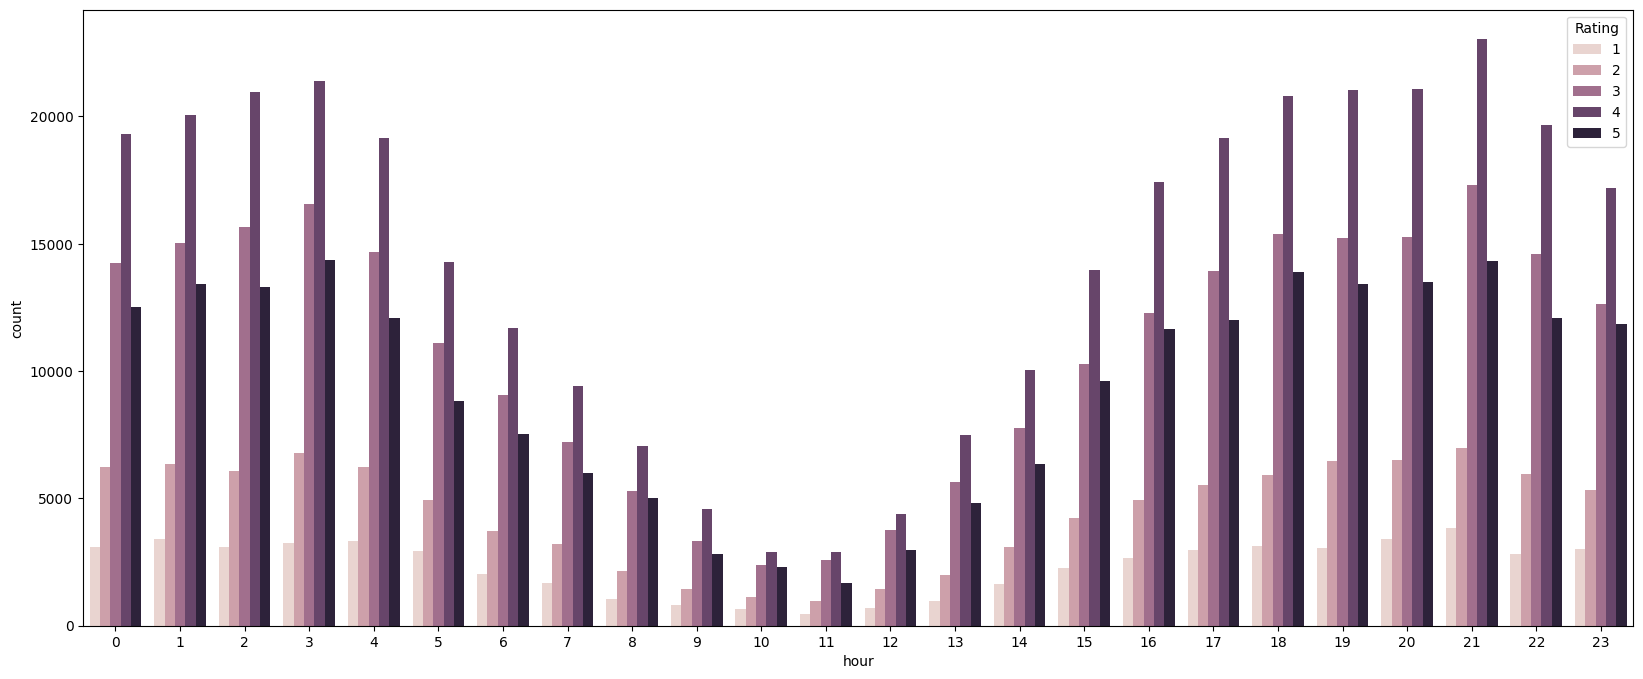

In [370]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "hour",hue = "Rating")

* Most of the movies are rated/watched in the Night and midnight
* Movies are least watched in morning and noon time

<Axes: xlabel='dayofweek', ylabel='count'>

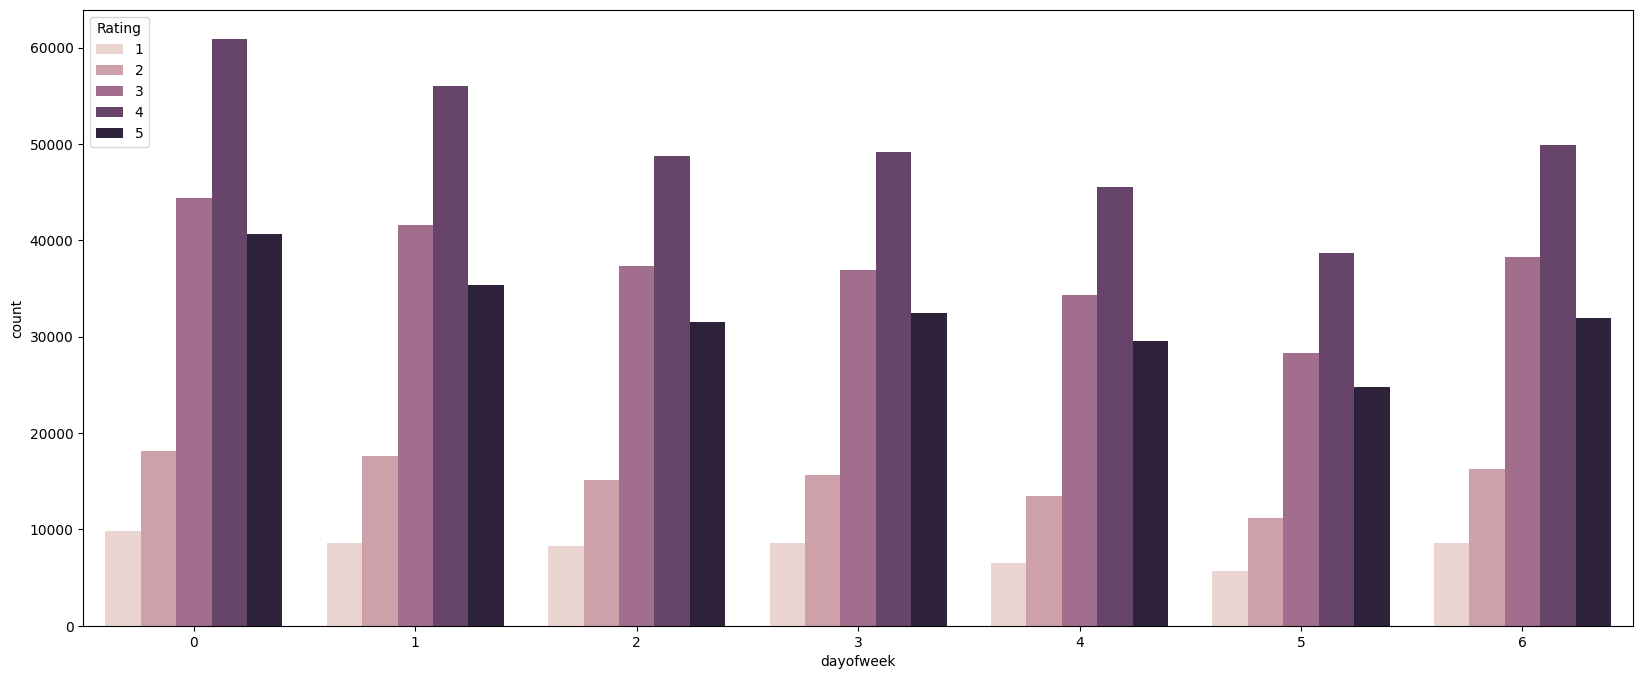

In [371]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "dayofweek",hue = "Rating")

* Comparitively movies are mostly watched in Saturdays and Sunday
* Least rated/watched on Fridays

<Axes: xlabel='month', ylabel='count'>

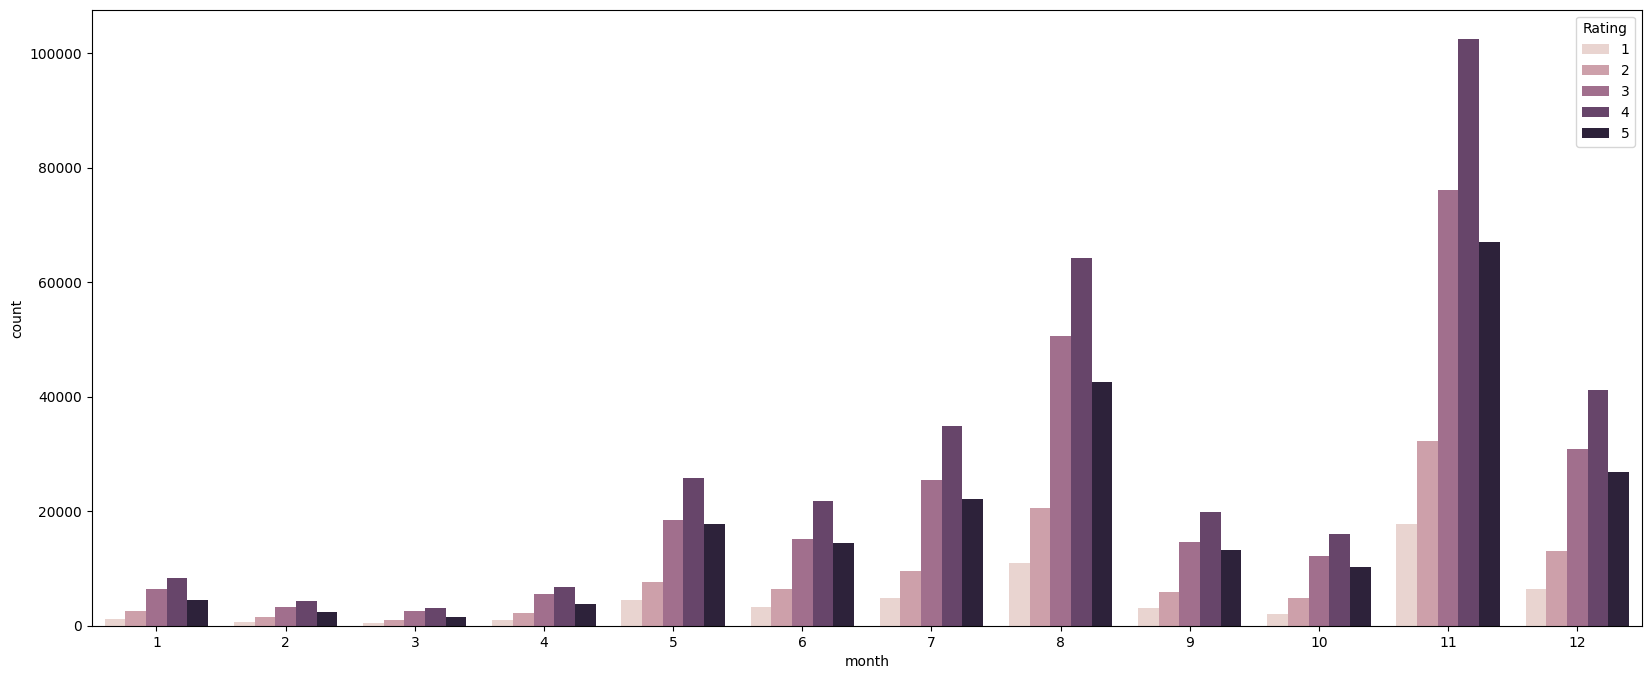

In [372]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "month",hue = "Rating")

* Most movies are watched /rated in the month of November & next in August
* leastly watchd /rated in the month of March

<Axes: xlabel='year', ylabel='count'>

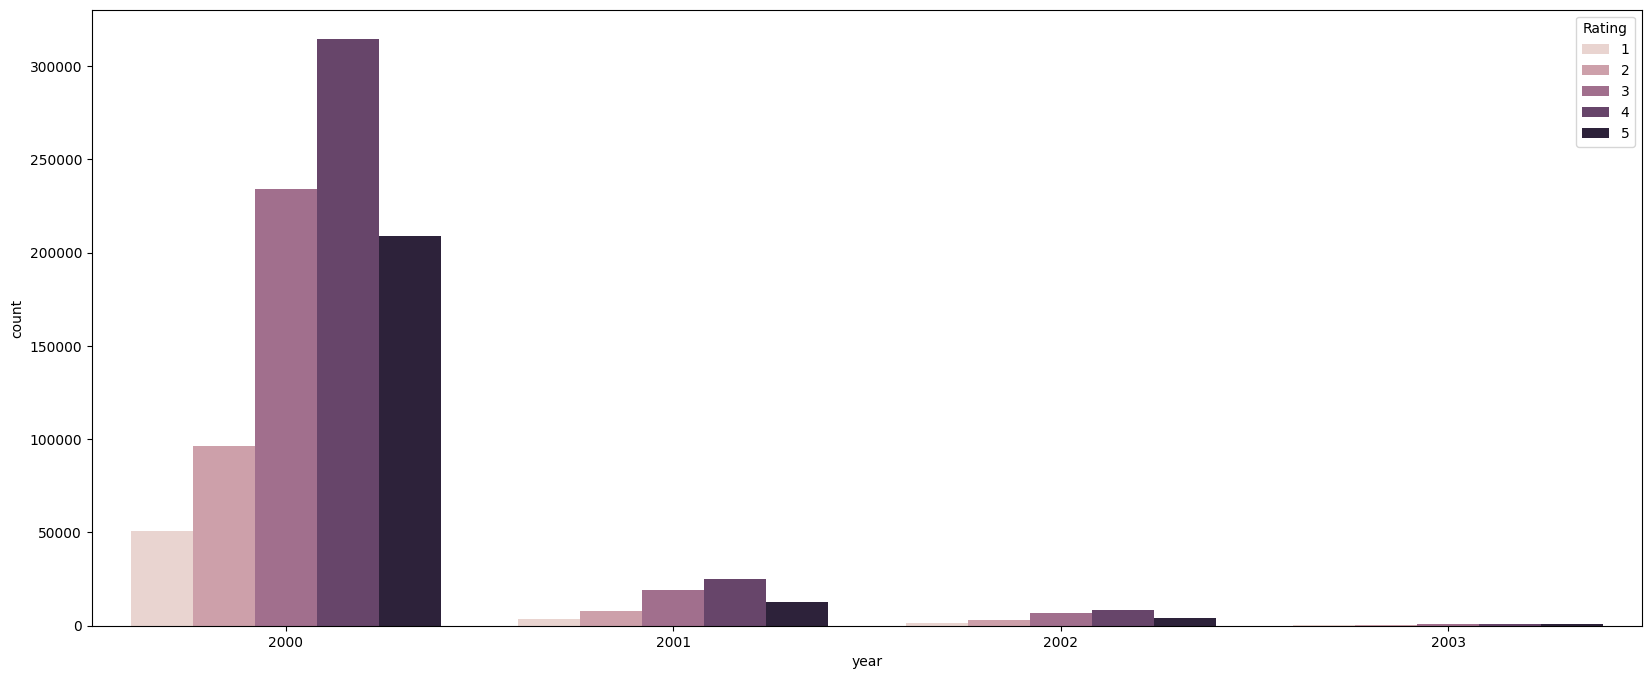

In [373]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "year",hue = "Rating")

In [374]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

# Creating Matrices

## Selecting 1000 Most Rated Movies & 1000 Most Watched users

In [375]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6174 entries, 0 to 3882
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Movie ID           6174 non-null   object  
 1   Title              6174 non-null   object  
 2   Genres             6174 non-null   category
 3   Genressplit        6174 non-null   object  
 4   Releaseyear        6174 non-null   int64   
 5   Releaseyeargroups  6171 non-null   category
dtypes: category(2), int64(1), object(3)
memory usage: 269.9+ KB


In [376]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [377]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [378]:
select_movies = ratings['Movie ID'].value_counts()[:1000].index.to_list()

In [379]:
movies = movies.loc[movies["Movie ID"].isin(select_movies)]
movies.shape

(2024, 6)

In [380]:
select_users = ratings['USerID'].value_counts()[:1000].index.to_list()

In [381]:
users = users.loc[users["USerID"].isin(select_users)]
users.shape

(1000, 5)

## Combination 3 Data frames

In [528]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [529]:
data = ratings.merge(users[["USerID","Gender","Age","Occupation"]],on = "USerID", how = "right")

In [530]:
data = data.merge(movies[["Movie ID","Title","Genres","Releaseyeargroups","Releaseyear"]],on = "Movie ID", how = 'right')

In [531]:
data.shape

(751539, 16)

In [532]:
data.head(10)

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day,Gender,Age,Occupation,Title,Genres,Releaseyeargroups,Releaseyear
0,10,1,5,978226474,1,6,12,2000,31,F,35,1,Toy Story (1995),Animation|Children's|Comedy,5,1995
1,18,1,4,978154768,5,5,12,2000,30,F,18,3,Toy Story (1995),Animation|Children's|Comedy,5,1995
2,23,1,4,978463614,19,1,1,2001,2,M,35,0,Toy Story (1995),Animation|Children's|Comedy,5,1995
3,26,1,3,978130703,22,4,12,2000,29,M,25,7,Toy Story (1995),Animation|Children's|Comedy,5,1995
4,36,1,5,978061285,3,4,12,2000,29,M,25,3,Toy Story (1995),Animation|Children's|Comedy,5,1995
5,45,1,4,977990044,7,3,12,2000,28,F,45,16,Toy Story (1995),Animation|Children's|Comedy,5,1995
6,48,1,4,977975909,3,3,12,2000,28,M,25,4,Toy Story (1995),Animation|Children's|Comedy,5,1995
7,92,1,4,977646817,8,6,12,2000,24,F,18,4,Toy Story (1995),Animation|Children's|Comedy,5,1995
8,117,1,3,977498304,15,4,12,2000,22,M,25,17,Toy Story (1995),Animation|Children's|Comedy,5,1995
9,123,1,3,978046755,23,3,12,2000,28,M,35,9,Toy Story (1995),Animation|Children's|Comedy,5,1995


In [545]:
data[data["Title"] == "Liar Liar (1997)"]

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day,Gender,Age,Occupation,Title,Genres,Releaseyeargroups,Releaseyear
344687,22,1485,1,978154074,5,5,12,2000,30,M,18,15,Liar Liar (1997),Comedy,5,1997
344688,26,1485,1,978139220,1,5,12,2000,30,M,25,7,Liar Liar (1997),Comedy,5,1997
344689,36,1485,4,978063740,4,4,12,2000,29,M,25,3,Liar Liar (1997),Comedy,5,1997
344690,45,1485,2,977990773,8,3,12,2000,28,F,45,16,Liar Liar (1997),Comedy,5,1997
344691,48,1485,3,978013525,14,3,12,2000,28,M,25,4,Liar Liar (1997),Comedy,5,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345079,5950,1485,1,957182791,12,0,5,2000,1,M,25,4,Liar Liar (1997),Comedy,5,1997
345080,5954,1485,1,957653882,22,5,5,2000,6,M,45,11,Liar Liar (1997),Comedy,5,1997
345081,5972,1485,4,963614933,22,4,7,2000,14,F,25,20,Liar Liar (1997),Comedy,5,1997
345082,6000,1485,4,956884024,1,4,4,2000,28,M,45,17,Liar Liar (1997),Comedy,5,1997


* Now we have all the required information in one Dataframe, from this Dataframe we can extract information for User-User and Item-Item Based Recommendation Approach

In [451]:
data1 = ratings.merge(users[["USerID","Gender","Age","Occupation"]],on = "USerID", how = "right")
data1 = data1.merge(movies[["Movie ID","Genres","Genressplit","Releaseyeargroups","Releaseyear"]],on = "Movie ID", how = 'right')

In [452]:
data1.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Genressplit', 'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

### EDA on Combined DataFrame

<Axes: xlabel='Rating', ylabel='Gender'>

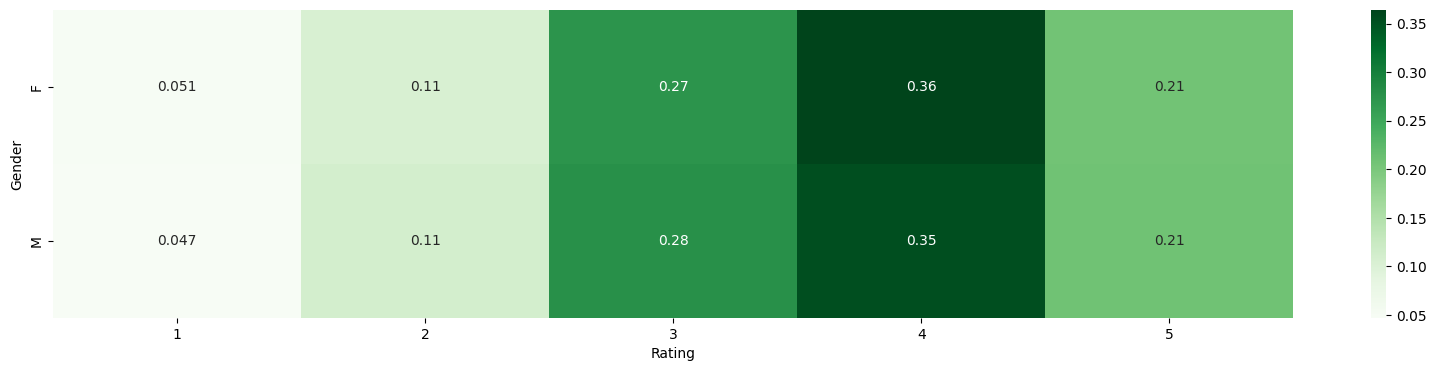

In [457]:
plt.figure(figsize = (20,4))
sns.heatmap(pd.crosstab(data["Gender"], data["Rating"], normalize = "index"),annot=True,cmap = "Greens")

* Gender has no Bias in Rating Viewpoint for Movies

<Axes: xlabel='Rating', ylabel='Age'>

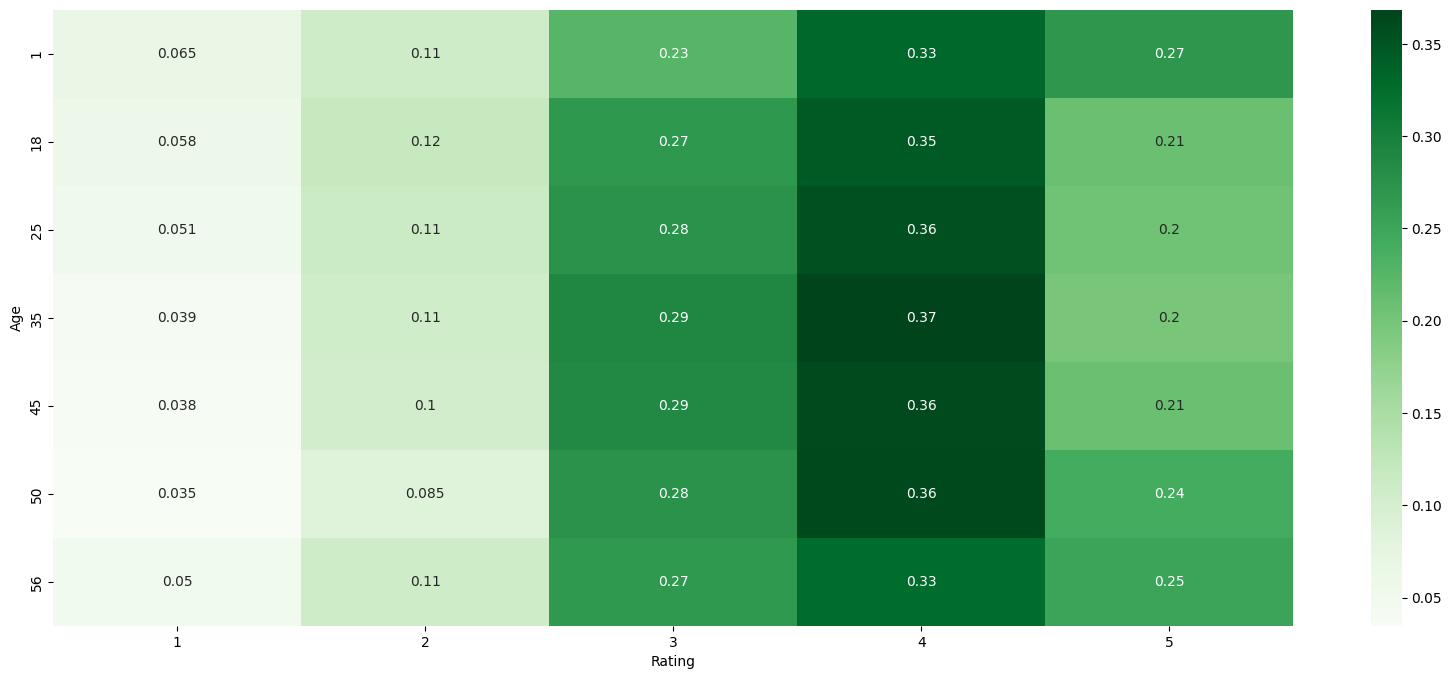

In [456]:
plt.figure(figsize = (20,8))
sns.heatmap(data=pd.crosstab(data["Age"], data["Rating"], normalize = "index"),annot=True,cmap = "Greens")

* Age Groups 18 ~ 25, 25 ~ 34, 35 ~ 44, 45 ~ 49 are comparively critical in rating movies in caomparison with other age groups

<Axes: xlabel='Genressplit', ylabel='Age'>

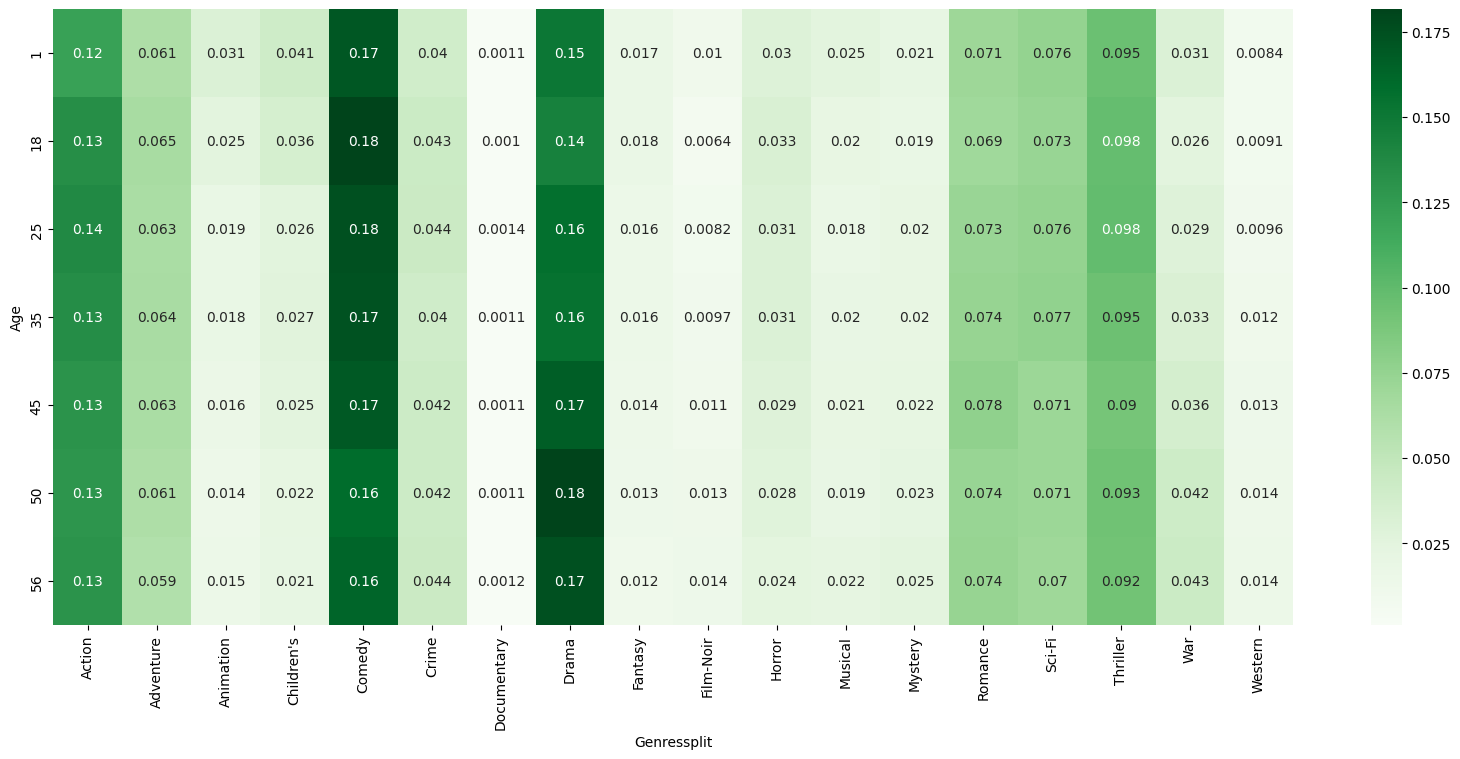

In [455]:
plt.figure(figsize = (20,8))
sns.heatmap(data=pd.crosstab(data1["Age"], data1["Genressplit"], normalize = "index"),annot=True,cmap = "Greens")

* All Age groups have almost preference order for Genres : Drama--> Comedy --> Action --> Thriller

<Axes: xlabel='Genressplit', ylabel='Gender'>

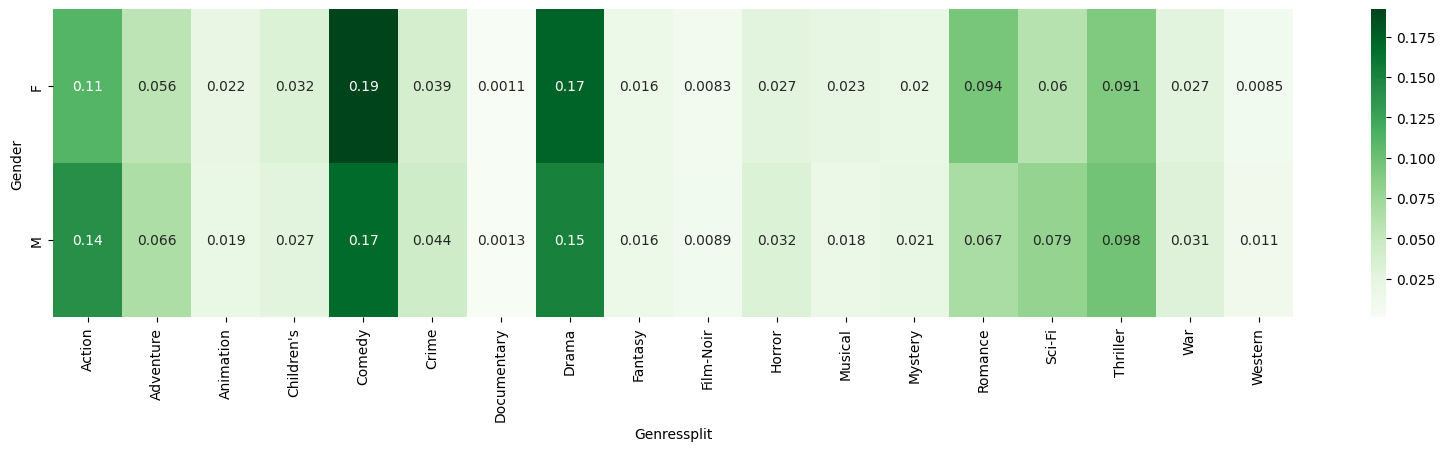

In [459]:
plt.figure(figsize = (20,4))
sns.heatmap(data=pd.crosstab(data1["Gender"], data1["Genressplit"], normalize = "index"),annot=True,cmap = "Greens")

* Female has more preference in Genres - Romance,Comedy,Drame in Comparison with Male
* Male has more preference in Genres - Action,Mystery in comparsion with Female

<Axes: xlabel='Genressplit', ylabel='Occupation'>

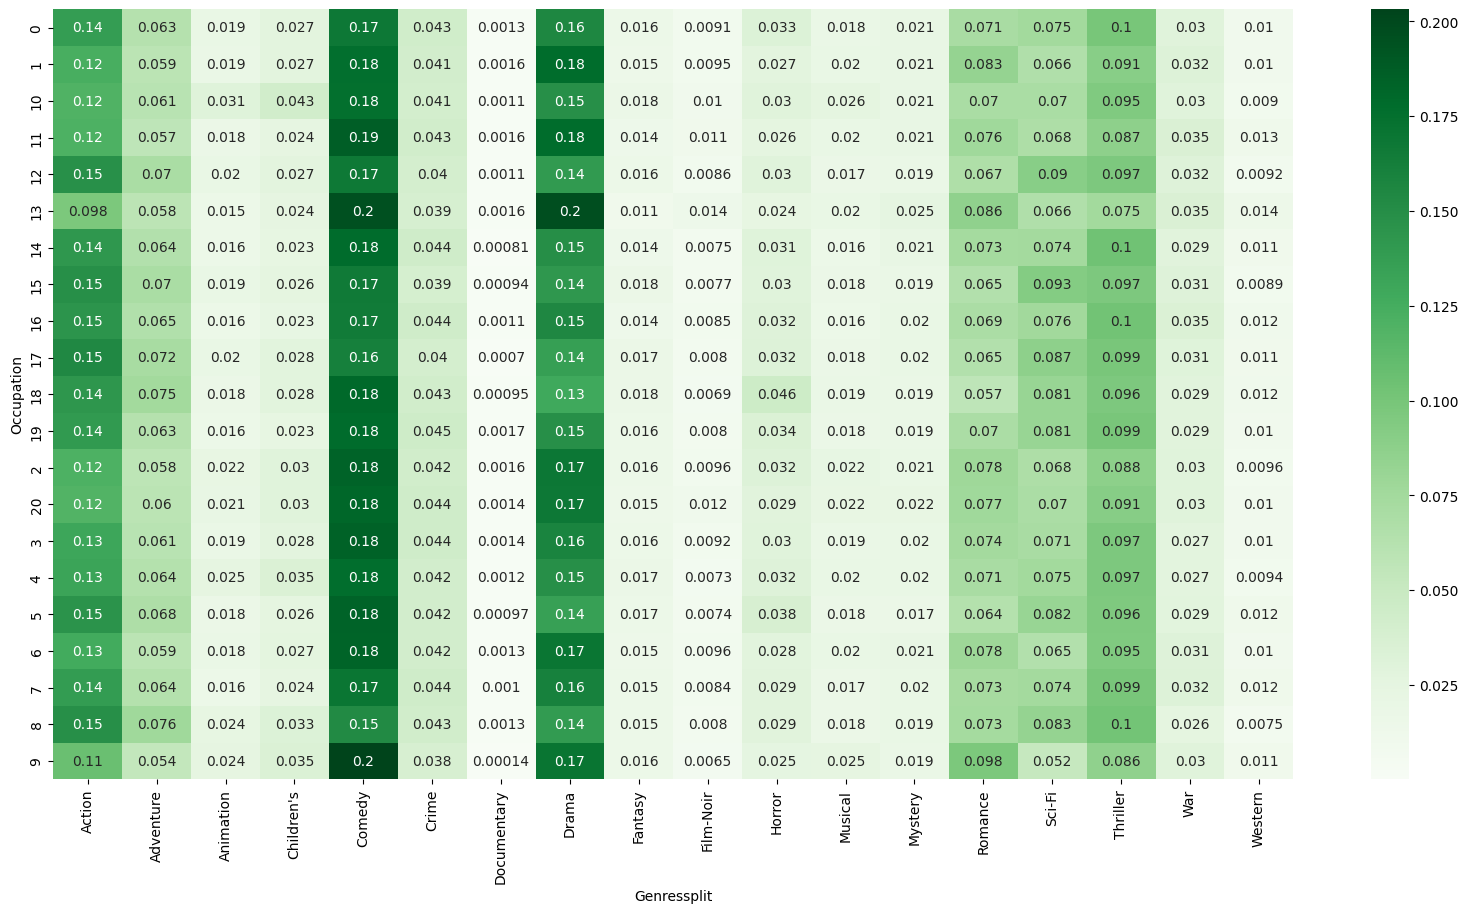

In [460]:
plt.figure(figsize = (20,10))
sns.heatmap(data=pd.crosstab(data1["Occupation"], data1["Genressplit"], normalize = "index"),annot=True,cmap = "Greens")

* Comparitively Retired & Homemaker People less preference for Action & have more prefence for Comedy and Drama

<Axes: xlabel='hour', ylabel='Age'>

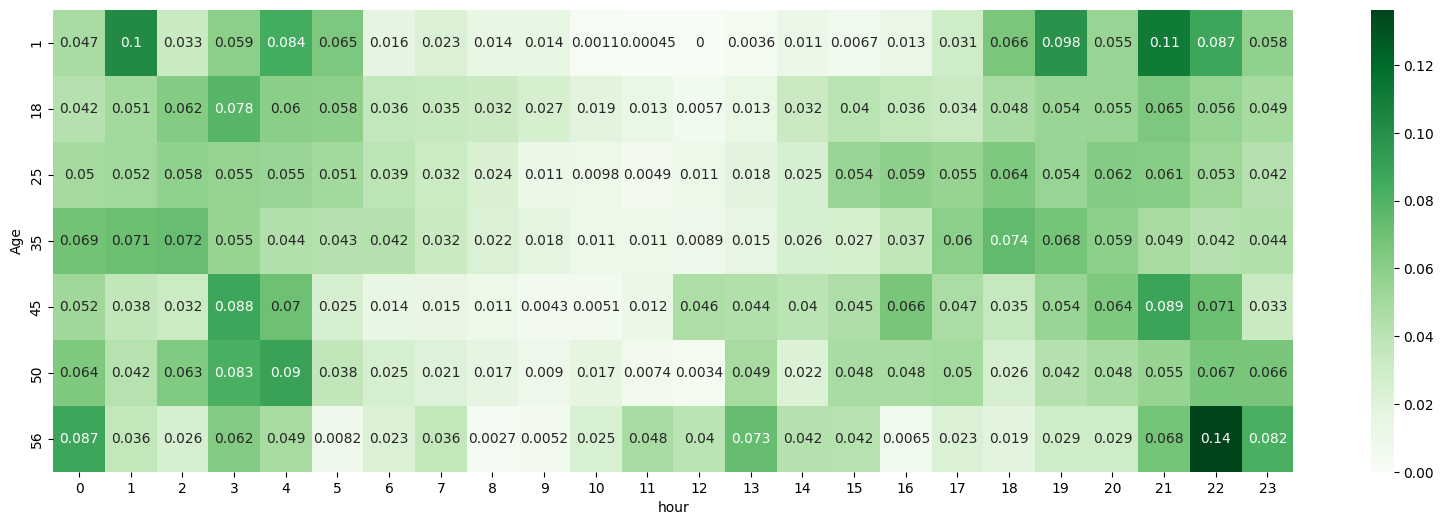

In [461]:
plt.figure(figsize = (20,6))
sns.heatmap(data=pd.crosstab(data1["Age"], data1["hour"], normalize = "index"),annot=True,cmap = "Greens")

* Compariively 56+ Age user watch/rate movie in the late night between 22:00 ~ 1:00

In [526]:
data["Occupation"].value_counts()[:5]

0     108154
4      99450
7      82286
1      60347
20     50098
Name: Occupation, dtype: int64

* Occupation:Others have rated most Movies, next most rated are College/Grad Student,executive/managerial,academic/educator,writer

In [527]:
data["Gender"].value_counts()

M    591777
F    159762
Name: Gender, dtype: int64

* Nearly 80% of ratings are done by Males

In [534]:
data["Title"].value_counts()[:5]

Men in Black (1997)                  3352
E.T. the Extra-Terrestrial (1982)    3208
Princess Bride, The (1987)           3136
Total Recall (1990)                  3000
L.A. Confidential (1997)             2928
Name: Title, dtype: int64

* Men in Black (1997) is most no. of times rated movie

## Item-Item Approach

Lets Create a Matrix for Item[Movie]

In [386]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [387]:
item_item = movies[['Movie ID','Releaseyear']].drop_duplicates()

In [388]:
item_item.head()

,Movie ID,Releaseyear
0,1,1995
1,2,1995
2,3,1995
5,6,1995
6,7,1995


In [389]:
item_item.shape

(976, 2)

### Adding Average Rating of an Item

In [390]:
item_item = item_item.merge(data.groupby('Movie ID').Rating.mean().reset_index(), on='Movie ID', how = "left")

In [391]:
item_item.head()

,Movie ID,Releaseyear,Rating
0,1,1995,4.118598
1,2,1995,3.144279
2,3,1995,2.874510
3,6,1995,3.836601
4,7,1995,3.231579


### Adding Genre By doing sort of OHE

In [392]:
m = movies.pivot(index='Movie ID', columns='Genressplit', values='Title')
m = ~m.isna()
m = m.astype(int)

In [393]:
m.head()

Genressplit,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1020,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1022,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1027,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [394]:
item_item = item_item.merge(m, on='Movie ID', how = "left")

### Adding Gender wise Ratings for an item

In [395]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Gender'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Gender', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [396]:
item_item.head()

,Movie ID,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,F,M
0,1,1995,4.118598,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.105263,4.122592
1,2,1995,3.144279,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.247059,3.116719
2,3,1995,2.874510,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.754098,2.912371
3,6,1995,3.836601,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.546667,3.893229
4,7,1995,3.231579,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.366972,3.147727


In [397]:
data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

### Adding Age wise Ratings for an item

In [398]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Age'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Age', values='Rating').
    reset_index(), on='Movie ID', how = "left")

### Adding Occupation wise Ratings for an item

In [399]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Occupation'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Occupation', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [400]:
item_item.shape

(976, 51)

### Final item_item Matrix

In [401]:
item_item.shape

(976, 51)

In [402]:
item_item.columns

Index(['Movie ID', 'Releaseyear', 'Rating', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'F', 'M', '1_x', '18_x', '25', '35', '45',
       '50', '56', '0', '1_y', '10', '11', '12', '13', '14', '15', '16', '17',
       '18_y', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [403]:
item_item =item_item.set_index("Movie ID")

In [404]:
item_item.fillna(0, inplace=True)

In [405]:
item_item.head(10)

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1995,4.118598,0,0,1,1,1,0,0,0,...,3.833333,4.000000,4.080000,4.481481,3.949495,4.142857,4.413793,4.222222,5.0,3.666667
2,1995,3.144279,0,1,0,1,0,0,0,0,...,2.833333,2.578947,3.000000,3.428571,3.087719,3.272727,3.352941,3.170732,4.0,3.400000
3,1995,2.874510,0,0,0,0,1,0,0,0,...,3.000000,2.272727,2.571429,2.727273,2.885714,2.600000,2.300000,2.777778,3.0,2.333333
6,1995,3.836601,1,0,0,0,0,1,0,0,...,4.000000,3.760000,3.466667,3.625000,3.916667,3.727273,4.250000,3.854167,4.0,4.333333
7,1995,3.231579,0,0,0,0,1,0,0,0,...,3.000000,2.941176,3.000000,2.750000,3.394737,3.200000,3.333333,3.088235,3.0,4.000000
10,1995,3.445396,1,1,0,0,0,0,0,0,...,2.833333,3.500000,3.115385,3.642857,3.623188,3.083333,3.666667,3.607843,3.0,3.200000
11,1995,3.661943,0,0,0,0,1,0,0,1,...,3.500000,3.333333,3.074074,3.437500,3.771429,4.111111,3.846154,3.666667,4.0,4.000000
16,1995,3.805970,0,0,0,0,0,0,0,1,...,3.000000,3.588235,3.550000,3.461538,4.019231,3.900000,4.230769,3.938776,3.0,3.500000
17,1995,3.955090,0,0,0,0,0,0,0,1,...,4.000000,3.923077,3.852941,3.666667,3.909091,3.666667,4.277778,3.941176,5.0,4.166667


In [406]:
scaler = MinMaxScaler()
item_item_scaled = pd.DataFrame(scaler.fit_transform(item_item), columns=item_item.columns, index=item_item.index)
item_item_scaled.head()

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,0.932432,0.839631,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.766667,0.776119,0.847000,0.861728,0.775395,0.828571,0.877833,0.833112,1.0,0.733333
2,0.932432,0.518590,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.566667,0.362529,0.550000,0.580952,0.511573,0.654545,0.605042,0.494968,0.8,0.680000
3,0.932432,0.429700,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.600000,0.273406,0.432143,0.393939,0.449731,0.520000,0.334286,0.368600,0.6,0.466667
6,0.932432,0.746712,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.800000,0.706269,0.678333,0.633333,0.765345,0.745455,0.835714,0.714751,0.8,0.866667
7,0.932432,0.547355,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.600000,0.467954,0.550000,0.400000,0.605562,0.640000,0.600000,0.468439,0.6,0.800000


In [407]:
item_item_scaled.describe()

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,...,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,0.820586,0.649157,0.258197,0.120902,0.047131,0.065574,0.360656,0.081967,0.003074,0.345287,...,0.693223,0.608559,0.666586,0.633772,0.652880,0.720561,0.685071,0.611456,0.558094,0.675603
std,0.190585,0.164862,0.437867,0.326180,0.212028,0.247662,0.480437,0.274455,0.055385,0.475705,...,0.152668,0.175338,0.162714,0.156204,0.167532,0.119536,0.143099,0.167957,0.361955,0.208961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.756757,0.541569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.600000,0.485075,0.550000,0.546667,0.538209,0.660000,0.600000,0.505477,0.200000,0.600000
50%,0.891892,0.670116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.700000,0.630597,0.687500,0.644444,0.673967,0.727922,0.707143,0.634895,0.600000,0.720000
75%,0.959459,0.772442,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.800000,0.734542,0.783750,0.733333,0.775004,0.800000,0.789796,0.734276,0.800000,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## User-User Approach

* Lets Create a Matric for User

In [408]:
users.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode'], dtype='object')

In [409]:
user_user = users[['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode']].drop_duplicates()

In [410]:
user_user.head()

,USerID,Gender,Age,Occupation,Zipcode
9,10,F,35,1,95370
17,18,F,18,3,95825
21,22,M,18,15,53706
22,23,M,35,0,90049
25,26,M,25,7,23112


### Adding Average Rating of a User

In [411]:
user_user = user_user.merge(data.groupby('USerID').Rating.mean().reset_index(), on='USerID', how = "left")

### Adding count of Movies rated by a user

In [412]:
user_user = user_user.merge(data.groupby('USerID').Rating.count().reset_index(), on='USerID', how = "left")

In [413]:
user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Rating_x',
       'Rating_y'],
      dtype='object')

In [414]:
user_user.rename(columns = {'Rating_x':'Ave.rating','Rating_y':'movie_count'}, inplace = True)

In [415]:
user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Ave.rating',
       'movie_count'],
      dtype='object')

### Adding Average Hour, weekday, day,month for rating for a user

In [416]:
data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

In [417]:
user_user = user_user.merge(data.groupby('USerID').hour.mean().reset_index(), on='USerID', how = "left")
user_user = user_user.merge(data.groupby('USerID').dayofweek.mean().reset_index(), on='USerID', how = "left")
user_user = user_user.merge(data.groupby('USerID').day.mean().reset_index(), on='USerID', how = "left")
user_user = user_user.merge(data.groupby('USerID').month.mean().reset_index(), on='USerID', how = "left")

### Label Encoding Gender

In [418]:
le=LabelEncoder()
user_user["Gender"]=le.fit_transform(user_user["Gender"])
user_user["Gender"].value_counts()

1    769
0    231
Name: Gender, dtype: int64

### Target Encoding Occupation and ZipCode

In [419]:
te=TargetEncoder()
user_user["Occupation"]=te.fit_transform(user_user["Occupation"],user_user["Ave.rating"])
user_user["Zipcode"]=te.fit_transform(user_user["Zipcode"],user_user["Ave.rating"])

In [420]:
user_user.head()

,USerID,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count,hour,dayofweek,day,month
0,10,0,35,3.515322,3.664194,4.175595,672,7.467262,4.901786,25.660714,8.824405
1,18,0,18,3.654193,3.599870,3.681208,596,5.127517,5.000000,30.000000,12.000000
2,22,1,18,3.640744,3.562083,3.043956,546,3.694139,4.864469,28.234432,10.269231
3,23,1,35,3.556170,3.563369,3.400668,599,17.934891,1.190317,4.313856,1.522538
4,26,1,25,3.623283,3.515404,3.032015,531,5.617702,5.160075,29.888889,11.875706


### Final user_user Matrix

In [421]:
user_user.shape

(1000, 11)

In [422]:
user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Ave.rating',
       'movie_count', 'hour', 'dayofweek', 'day', 'month'],
      dtype='object')

In [423]:
user_user =user_user.set_index("USerID")

In [424]:
item_item.fillna(0, inplace=True)

In [425]:
scaler1 = MinMaxScaler()
user_user_scaled = pd.DataFrame(scaler1.fit_transform(user_user), columns=user_user.columns, index=user_user.index)
user_user_scaled.head()

,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count,hour,dayofweek,day,month
USerID,,,,,,,,,,
10,0.0,0.618182,0.000000,0.788443,0.792383,0.275701,0.324758,0.816964,0.822024,0.696912
18,0.0,0.309091,0.712702,0.583916,0.591665,0.224967,0.221804,0.833333,0.966667,1.000000
22,1.0,0.309091,0.643679,0.463769,0.332945,0.191589,0.158732,0.810745,0.907814,0.834810
23,1.0,0.618182,0.209636,0.467857,0.477768,0.226969,0.785358,0.198386,0.110462,0.000000
26,1.0,0.436364,0.554071,0.315346,0.328097,0.181575,0.243374,0.860013,0.962963,0.988137


In [426]:
user_user_scaled.describe()

,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count,hour,dayofweek,day,month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.769000,0.510291,0.358780,0.544965,0.553703,0.328798,0.512404,0.472405,0.483055,0.679194
std,0.421683,0.192363,0.236672,0.154116,0.161523,0.172675,0.265990,0.276812,0.250430,0.206929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.436364,0.209636,0.452679,0.461019,0.202937,0.269487,0.260886,0.273486,0.523728
50%,1.000000,0.436364,0.245048,0.551051,0.559761,0.291389,0.532134,0.462721,0.514520,0.642360
75%,1.000000,0.618182,0.554071,0.655041,0.664233,0.428571,0.750270,0.666667,0.663106,0.898473
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## User_Item Intraction Matrix

In [427]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [428]:
user_item = ratings.pivot(index = 'USerID',columns ='Movie ID',values = 'Rating' )

In [429]:
user_item.fillna(0,inplace = True)

In [430]:
user_item.shape

(6040, 3706)

In [431]:
user_item.head()

Movie ID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
USerID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
# Findind No of Ratings
(user_item >0).sum().sum()

1000209

In [433]:
# Finding Sprsity in User_Item Interaction Matrix

(user_item >0).sum().sum() / (user_item.shape[0]*user_item.shape[1])

0.044683625622312845

* Only 4.46 % of ratings are filled in User_Item Interaction Matrix

# Pearson Correltion for Item Item Recommendation

In [548]:
item_item_scaled.shape

(976, 50)

In [549]:
item_item_scaled.index

Index(['1', '2', '3', '6', '7', '10', '11', '16', '17', '19',
       ...
       '3863', '3868', '3869', '3893', '3897', '3911', '3916', '3927', '3948',
       '3952'],
      dtype='object', name='Movie ID', length=976)

* Creating a DataFrame for a Query and All Candidates with Peason Correlation

In [550]:
ranks = []

for query in item_item_scaled.index:
    for candidate in item_item_scaled.index:
        if candidate == query:
            continue
        ranks.append([query, candidate, pearsonr(item_item_scaled.loc[query], item_item_scaled.loc[candidate])[0]])


Pearson_Item_df = pd.DataFrame(ranks, columns=['query', 'candidate', 'Pearson'])
Pearson_Item_df.head()

KeyboardInterrupt: 

In [ ]:
movies.columns

In [ ]:
Pearson_Item_df = Pearson_Item_df.merge(movies[['Movie ID', 'Title']], left_on='query', right_on='Movie ID').rename(columns={'Title': 'query_title'}).drop(columns=['Movie ID'])
Pearson_Item_df = Pearson_Item_df.merge(movies[['Movie ID', 'Title']], left_on='candidate', right_on='Movie ID').rename(columns={'Title': 'Rec_candidate_title'}).drop(columns=['Movie ID'])
Pearson_Item_df = Pearson_Item_df.sort_values(by=['query', 'Pearson'], ascending = [True, False])
Pearson_Item_df.drop_duplicates(inplace=True)
Pearson_Item_df.head()

In [ ]:
Pearson_Item_df.drop_duplicates(inplace=True)

In [ ]:
Pearson_Item_df.shape

In [ ]:
Pearson_Item_df = Pearson_Item_df.sort_values(by=['query', 'Pearson'], ascending = [True, False])

In [ ]:
Pearson_Item_df.head()

## Function for Item-Item Recommendation using Pearson Correaltion Coefficient

In [ ]:
# This function work only if we precalculate all possible pearson correlation values for Item vs Item
# But this is efficient as we have to calcuate Pearson Correlation values only once
# and we can query through below function multiple time

def Item_Rec(data,Movie_ID,k):
  # Data is pearson Correlation Dataframe for all item vs item
  # Movie_ID --> Item for which we are finding simialar movies
  # k --> No of Recommenadions Required
  return (data.loc[data["query"] == Movie_ID])[:k]

In [ ]:
Item_Rec(data = Pearson_Item_df ,Movie_ID = "1",k=5)

In [ ]:
Item_Rec(data = Pearson_Item_df ,Movie_ID = "1485",k=3)

# Cosine Simialrity Matrix for items

In [462]:
Cosine_Item_Matrix= cosine_similarity(item_item_scaled)

In [463]:
Cosine_Item_Matrix.shape

(976, 976)

In [464]:
Cosine_Item_Matrix

array([[1.        , 0.87006646, 0.88116146, ..., 0.84282108, 0.90654986,
        0.82580961],
       [0.87006646, 1.        , 0.77969586, ..., 0.84228991, 0.82098621,
        0.77555389],
       [0.88116146, 0.77969586, 1.        , ..., 0.7742923 , 0.88098996,
        0.76826642],
       ...,
       [0.84282108, 0.84228991, 0.7742923 , ..., 1.        , 0.83453074,
        0.82651856],
       [0.90654986, 0.82098621, 0.88098996, ..., 0.83453074, 1.        ,
        0.88169918],
       [0.82580961, 0.77555389, 0.76826642, ..., 0.82651856, 0.88169918,
        1.        ]])

In [465]:
Cosine_Item_Mat_df = pd.DataFrame(Cosine_Item_Matrix, index = item_item_scaled.index, columns = item_item_scaled.index )

In [466]:
Cosine_Item_Mat_df

Movie ID,1,2,3,6,7,10,11,16,17,19,...,3863,3868,3869,3893,3897,3911,3916,3927,3948,3952
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.870066,0.881161,0.863783,0.905579,0.836112,0.902030,0.856726,0.876303,0.844698,...,0.825611,0.951386,0.937018,0.894715,0.936804,0.953418,0.860025,0.842821,0.906550,0.825810
2,0.870066,1.000000,0.779696,0.805213,0.805253,0.857140,0.806551,0.816625,0.818021,0.734305,...,0.796189,0.848157,0.836826,0.793096,0.834635,0.849304,0.820522,0.842290,0.820986,0.775554
3,0.881161,0.779696,1.000000,0.813927,0.983843,0.790526,0.949329,0.796574,0.882326,0.880996,...,0.771802,0.924591,0.938131,0.877770,0.898160,0.922586,0.800100,0.774292,0.880990,0.768266
6,0.863783,0.805213,0.813927,1.000000,0.844156,0.936083,0.846084,0.898857,0.865581,0.756206,...,0.871590,0.894587,0.869301,0.892155,0.884865,0.897956,0.850961,0.824869,0.846936,0.862837
7,0.905579,0.805253,0.983843,0.844156,1.000000,0.820446,0.962502,0.836780,0.909549,0.872103,...,0.806187,0.948002,0.949328,0.906529,0.924366,0.944451,0.835908,0.802116,0.910420,0.794295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,0.953418,0.849304,0.922586,0.897956,0.944451,0.867288,0.939398,0.889948,0.910967,0.896029,...,0.848359,0.990592,0.980210,0.929954,0.972405,1.000000,0.885320,0.867956,0.939537,0.853665
3916,0.860025,0.820522,0.800100,0.850961,0.835908,0.843586,0.906543,0.947713,0.906447,0.734827,...,0.839612,0.890384,0.849674,0.876370,0.939827,0.885320,1.000000,0.836448,0.928057,0.944069
3927,0.842821,0.842290,0.774292,0.824869,0.802116,0.866246,0.812453,0.829250,0.864123,0.712889,...,0.856874,0.869017,0.827917,0.813153,0.860942,0.867956,0.836448,1.000000,0.834531,0.826519


### Function for Item Recommendation

In [514]:
# This function work only if we precalculate Cosine matrix for Item vs Item
# But this is efficient as we have to calcuate Cosine Matric values only once
# and we can query through below function multiple time

def Item_Rec_cosine(data,Movie_ID,k):
  # Data is pearson Correlation Dataframe for all item vs item
  # Movie_ID --> Item for which we are finding simialar movies
  # k --> No of Recommenadions Required
  iloc_indices = np.argsort(data.loc[Movie_ID,:].values)[::-1]
  return data.index[iloc_indices][1:k+1]

In [515]:
Item_Rec_cosine(Cosine_Item_Mat_df,"1",5)

Index(['3114', '2355', '3751', '1148', '1223'], dtype='object', name='Movie ID')

In [516]:
movies[movies["Movie ID"].isin(Item_Rec_cosine(Cosine_Item_Mat_df,"1",5))]

,Movie ID,Title,Genres,Genressplit,Releaseyear,Releaseyeargroups
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy,Animation,1993,5
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy,Comedy,1993,5
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,Animation,1992,5
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,Comedy,1992,5
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,Animation,1998,5
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,Children's,1998,5
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,Comedy,1998,5
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,Animation,1999,5
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,Children's,1999,5
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,Comedy,1999,5


* We can see that above recommendations are similar to Movie_ID "1"

* Movies recommended of Movie_ID "1" are exactly same what was observed inPeason Correlation Method [3114,2355,3751,1148,1223]

# Cosine Similarity Matrix for Users

In [ ]:
Cosine_User_Matrix= cosine_similarity(user_user_scaled)

In [ ]:
Cosine_User_Matrix.shape

(1000, 1000)

In [ ]:
Cosine_User_Matrix

array([[1.        , 0.89519699, 0.75665161, ..., 0.71989674, 0.81829577,
        0.65972244],
       [0.89519699, 1.        , 0.86142648, ..., 0.60438336, 0.87533041,
        0.75412339],
       [0.75665161, 0.86142648, 1.        , ..., 0.76970319, 0.75548841,
        0.89926712],
       ...,
       [0.71989674, 0.60438336, 0.76970319, ..., 1.        , 0.70726427,
        0.79418284],
       [0.81829577, 0.87533041, 0.75548841, ..., 0.70726427, 1.        ,
        0.78261326],
       [0.65972244, 0.75412339, 0.89926712, ..., 0.79418284, 0.78261326,
        1.        ]])

In [ ]:
Cosine_User_Mat_df = pd.DataFrame(Cosine_User_Matrix, index = user_user_scaled.index, columns = user_user_scaled.index )

In [ ]:
Cosine_User_Mat_df

USerID,10,18,22,23,26,33,36,45,48,53,...,5972,5978,5996,6000,6002,6007,6010,6016,6036,6040
USerID,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.895197,0.756652,0.553219,0.768487,0.728542,0.834231,0.901144,0.792549,0.852962,...,0.902982,0.783239,0.888107,0.753340,0.816872,0.664578,0.793259,0.719897,0.818296,0.659722
18,0.895197,1.000000,0.861426,0.431495,0.860889,0.739296,0.881037,0.932471,0.820832,0.824501,...,0.786923,0.692386,0.795704,0.757997,0.715574,0.673205,0.695773,0.604383,0.875330,0.754123
22,0.756652,0.861426,1.000000,0.655572,0.991216,0.870173,0.961088,0.808064,0.953526,0.909001,...,0.647162,0.876034,0.660005,0.914364,0.850119,0.826797,0.832848,0.769703,0.755488,0.899267
23,0.553219,0.431495,0.655572,1.000000,0.648226,0.904932,0.753381,0.494801,0.694357,0.742662,...,0.700219,0.869431,0.692031,0.808331,0.821118,0.897099,0.922009,0.891348,0.539521,0.827917
26,0.768487,0.860889,0.991216,0.648226,1.000000,0.868386,0.945340,0.836442,0.967750,0.904870,...,0.658124,0.892831,0.661697,0.901965,0.842812,0.826085,0.825871,0.789353,0.737641,0.868976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,0.664578,0.673205,0.826797,0.897099,0.826085,0.966766,0.872295,0.707559,0.829235,0.820005,...,0.771775,0.906207,0.796251,0.909949,0.789386,1.000000,0.943428,0.924932,0.752875,0.931418
6010,0.793259,0.695773,0.832848,0.922009,0.825871,0.947242,0.911460,0.720502,0.856693,0.904323,...,0.840428,0.959548,0.841199,0.917993,0.910751,0.943428,1.000000,0.938525,0.734133,0.895360
6016,0.719897,0.604383,0.769703,0.891348,0.789353,0.896161,0.814121,0.681494,0.863014,0.847061,...,0.782614,0.957173,0.808057,0.882029,0.817658,0.924932,0.938525,1.000000,0.707264,0.794183


### Function for Similar User Recommendation

In [502]:
# This function work only if we precalculate Cosine matrix for User vs User
# But this is efficient as we have to calcuate Cosine Matric values only once
# and we can query through below function multiple time

def User_Rec_cosine(data,User_ID,k):
  # Data is pearson Correlation Dataframe for all User vs User
  # User_ID --> User for which we are finding simialar Users
  # k --> No of Recommenadions Required
  iloc_indices = np.argsort(data.loc[User_ID,:].values)[::-1]
  return data.index[iloc_indices][1:k+1]

In [503]:
User_Rec_cosine(Cosine_User_Mat_df,"10",5)

Index(['151', '5271', '919', '1701', '1164'], dtype='object', name='USerID')

In [506]:
users.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode'], dtype='object')

In [512]:
users[users["USerID"].isin(User_Rec_cosine(Cosine_User_Mat_df,"10",5))]

,USerID,Gender,Age,Occupation,Zipcode
150,151,F,25,20,85013
918,919,F,35,1,92056
1163,1164,F,25,19,90020
1700,1701,F,25,4,97233
5270,5271,F,25,0,94110


* We can see that above recommendations are similar to User_ID "10"

# Nearest Neighbours Algorithm for Item Recommendation with Cosine Metric

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

In [ ]:
model_knn.fit(item_item_scaled)

NearestNeighbors(algorithm='brute', metric='cosine')

* Now we will find 5 Nearest Neighbour for Movie_ID = 1

In [ ]:
# k in the Movie_ID
k = "1"
distances, indices = model_knn.kneighbors(item_item_scaled.loc[k,:].values.reshape(1, -1), n_neighbors = 6)

In [ ]:
distances

array([[0.        , 0.00248231, 0.00257019, 0.00528172, 0.02423075,
        0.02435134]])

In [ ]:
indices

array([[  0, 806, 602, 950, 266, 295]])

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(item_item_scaled.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, item_item_scaled.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 1:

1: 3114, with distance of 0.00248231289646883:
2: 2355, with distance of 0.0025701919525846773:
3: 3751, with distance of 0.005281715411900256:
4: 1148, with distance of 0.024230750204634388:
5: 1223, with distance of 0.024351342474249527:


* Nearest Neight Algorithm also Recommended same Movies fr Movie_ID "1" simialr to Pearson Correlation and Cosine simialrity

# Matrix Factorization with k(Embeddings)= 4

In [ ]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [517]:
user_item1 = ratings[['USerID', 'Movie ID', 'Rating']]

In [ ]:
user_item1['USerID'].nunique()

6040

In [ ]:
user_item1['Movie ID'].nunique()

3706

In [ ]:
user_item1.shape

(1000209, 3)

In [518]:
#  Changing columns as per library requirement
user_item1.columns = ['UserId', 'ItemId', 'Rating']

In [519]:
user_item1.head()

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [520]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
model.fit(user_item1)

Collective matrix factorization model
(explicit-feedback variant)


In [521]:
model.A_.shape

(6040, 4)

In [522]:
model.B_.shape

(3706, 4)

In [ ]:
# Finding Predicted Rating for all Interactions
np.dot(model.A_, model.B_.T)

array([[-0.22948895, -0.38242546,  0.07186198, ..., -0.16327427,
        -0.23036666,  0.04428816],
       [-0.36907816, -0.37764624,  0.47913522, ..., -0.05196466,
        -0.10314548,  0.02455359],
       [-0.47322673, -0.36404192, -0.20490578, ..., -0.22136272,
        -0.20130685, -0.00387301],
       ...,
       [-0.99852836, -0.12333941,  0.15010752, ..., -0.00315326,
         0.20635262, -0.13794099],
       [-0.11629342,  0.00380674,  0.1834784 , ...,  0.04070282,
         0.02041265, -0.01076825],
       [ 0.36193278,  0.56550443, -0.00564478, ...,  0.23328021,
         0.19428274, -0.0382481 ]], dtype=float32)

In [ ]:
# Final Predicted Rating matrix  [dot(User, Item)+ user Bias + Item bias + Global Rating Mean]
user_item_pred = np.dot(model.A_, model.B_.T) + model.user_bias_.reshape(-1, 1)+ model.item_bias_.reshape(1, -1) + model.glob_mean_

In [ ]:
user_item_pred = pd.DataFrame(user_item_pred, columns = user_item.columns, index = user_item.index)

In [ ]:
user_item_pred

Movie ID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
USerID,,,,,,,,,,,,,,,,,,,,,
1,4.333495,3.188670,4.219245,4.184110,3.803981,4.290605,4.594391,4.422247,4.590399,4.315201,...,3.534152,4.313815,4.035079,3.595278,3.862863,4.864362,3.105049,1.412619,4.176008,4.017798
10,3.969983,2.969526,4.402596,4.185825,3.709589,4.065962,4.367632,4.136885,4.570137,4.346762,...,3.288252,4.159964,3.848906,3.367805,3.637520,4.320831,2.851356,1.300005,4.079306,3.774141
100,4.128202,3.245499,3.980923,4.167925,3.631841,4.364059,3.930409,4.118989,3.828007,4.023709,...,3.375077,4.982054,4.058735,3.615774,3.917556,4.154002,3.176496,1.392975,4.243513,4.008082
1000,4.808551,3.847477,4.297471,3.459938,4.111794,4.249291,4.312610,4.487895,4.468925,4.805585,...,3.084459,4.512967,3.810835,3.274061,3.515534,3.189830,2.636032,1.623991,4.318335,3.679024
1001,3.997905,3.117397,3.031715,2.593992,2.945951,3.552661,2.987324,3.546302,3.117285,3.520792,...,2.378847,4.075969,3.091537,2.632554,2.911162,2.812785,2.125735,0.751135,3.389384,3.039845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.446848,3.490171,3.820152,3.310775,3.719384,4.062055,3.911000,4.156456,3.901362,4.274743,...,2.900009,4.479270,3.629959,3.125385,3.383956,3.147267,2.544312,1.304223,4.050930,3.527829
996,4.192039,3.149032,3.812319,3.518573,3.619547,3.980602,4.058711,4.085215,3.972115,4.122580,...,2.961611,4.265916,3.618758,3.130378,3.389986,3.557965,2.571515,1.164302,3.960178,3.537775
997,3.868599,3.751900,4.601635,4.674826,3.927784,4.753085,2.981449,3.752574,3.081795,4.365089,...,3.209965,6.621392,4.388346,3.836277,4.195067,2.140124,3.397312,1.876884,4.916871,4.139713


In [ ]:
user_item_pred.loc["1000"]["1"]

4.808551

In [ ]:
user_item.loc["1000"]["1"]

5.0

### MAPE Metric

In [ ]:
user_item.values[user_item > 0]

array([5., 5., 5., ..., 2., 2., 2.])

In [ ]:
user_item_pred.values[user_item > 0]

array([4.333495 , 4.4208403, 3.5126076, ..., 0.2085023, 2.641737 ,
       2.3006194], dtype=float32)

In [ ]:
mape(user_item.values[user_item > 0],user_item_pred.values[user_item > 0] )

0.427507060167678

### MSE

In [ ]:
mse(user_item.values[user_item > 0],user_item_pred.values[user_item > 0] )

2.235840644716731

### MAE

In [ ]:
mae(user_item.values[user_item > 0],user_item_pred.values[user_item > 0] )

1.1930984183148428

* Looking at the Error value, we can say that embeddings have to be increased to get better results
* Lets do Hyperparameter Tuning for No of Embeddings

In [ ]:
MAE = []
for i in range(2,16):
  model = CMF(method="als", k=i, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
  model.fit(user_item1)
  user_item_pred = np.dot(model.A_, model.B_.T) + model.user_bias_.reshape(-1, 1)+ model.item_bias_.reshape(1, -1) + model.glob_mean_
  MAE.append(mae(user_item.values[user_item > 0],user_item_pred[user_item > 0]))

Text(0, 0.5, 'MAE Error')

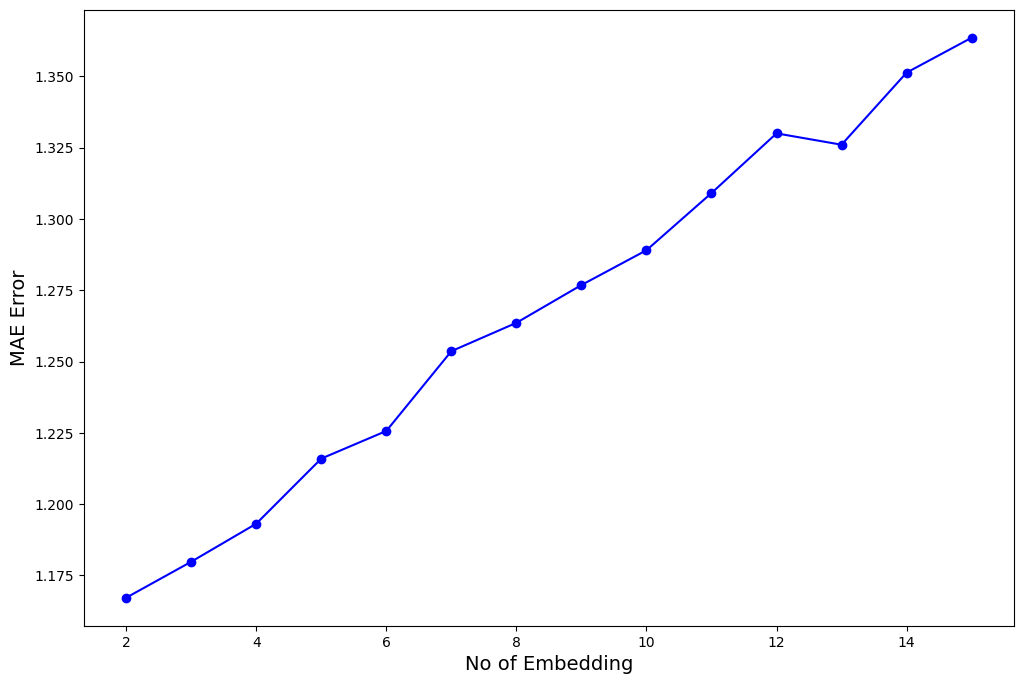

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(2, 16), MAE, "bo-")
plt.xlabel("No of Embedding", fontsize=14)
plt.ylabel("MAE Error", fontsize=14)

* MAE Error is increasing with increase in No of Embeddings
* As Sparsity of the Matrix is very high, we are not getting Better Results
* To get Better Results, we have increase more User-Item Ratings

## Embedding Visualizaton with k=4

In [ ]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
model.fit(user_item1)
user_item_pred = np.dot(model.A_, model.B_.T) + model.user_bias_.reshape(-1, 1)+ model.item_bias_.reshape(1, -1) + model.glob_mean_

In [ ]:
# Users
model.A_.shape

(6040, 4)

In [ ]:
# Items
model.B_.shape

(3706, 4)

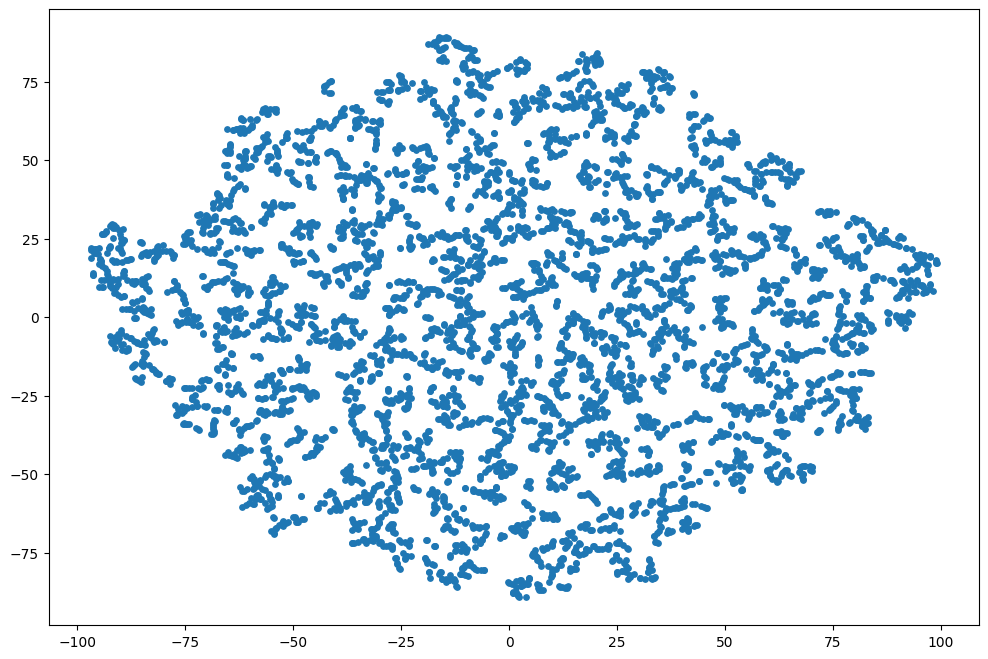

In [ ]:
# User Visualization using tSNE
usertsne = TSNE(n_components = 2, perplexity = 15, random_state = 0)
Z = usertsne.fit_transform(model.A_)


fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1], s=15)

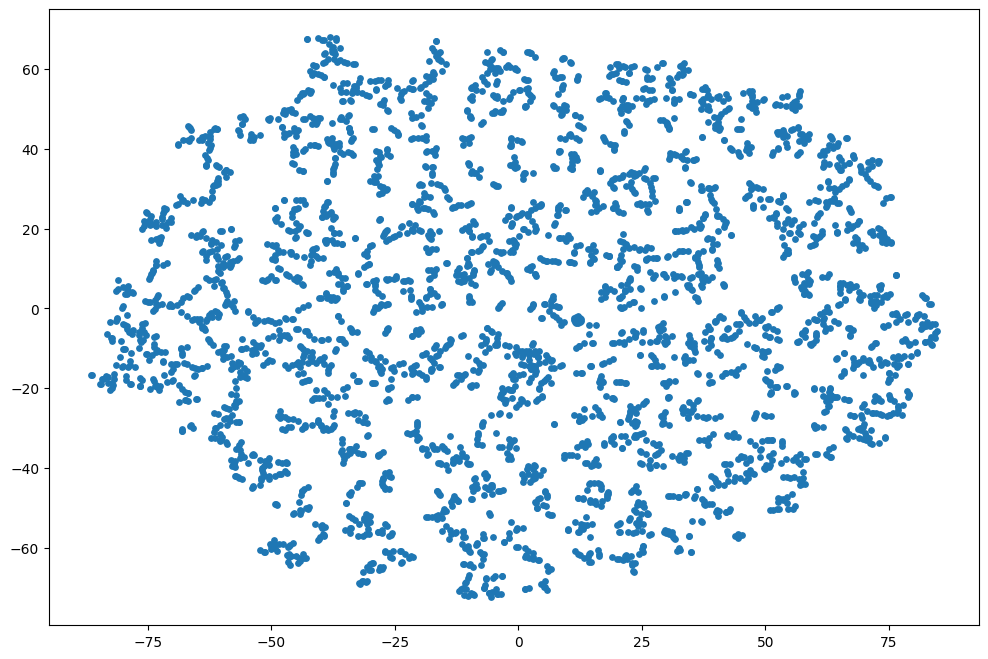

In [ ]:
# Items Visualization using tSNE
itemtsne = TSNE(n_components = 2, perplexity = 15, random_state = 0)
Z = usertsne.fit_transform(model.B_)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1],s=15)

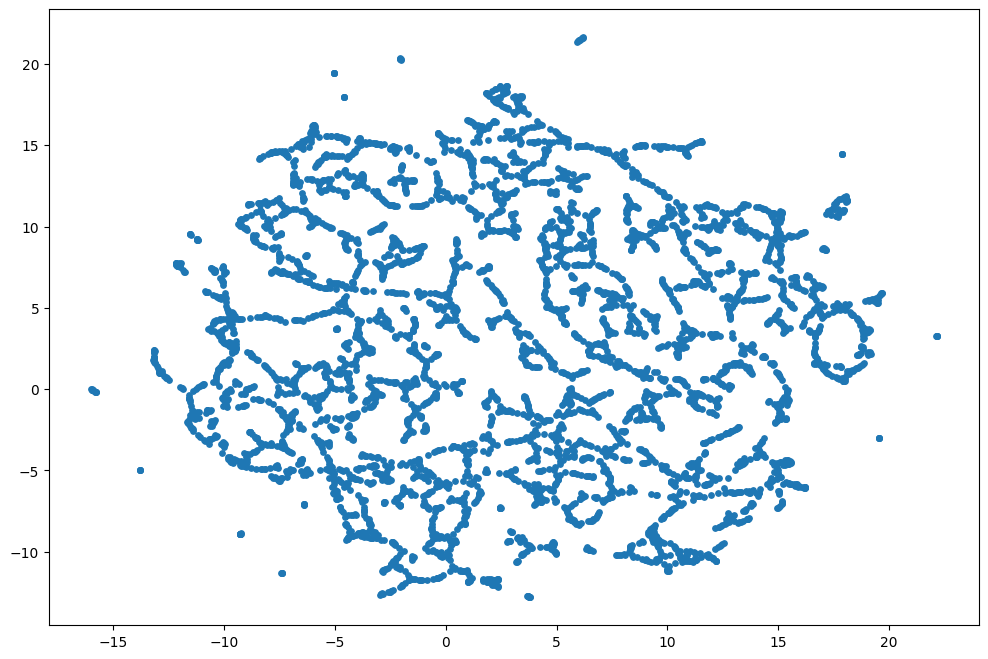

In [ ]:
# Users Visualization using UMAP
userumap = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
Z = userumap.fit_transform(model.A_)


fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1], s=15)

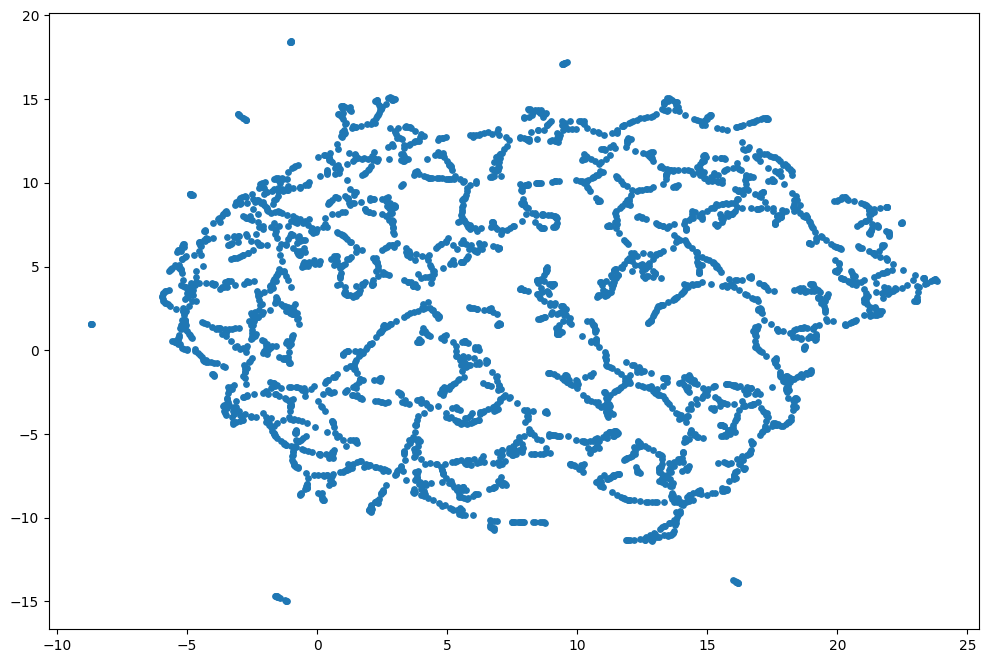

In [ ]:
# Items Visualization using UMAP
itemumap = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
Z = itemumap.fit_transform(model.B_)


fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1], s=15)

* From MF Embdedding Visualization, we are not able to clearly see Clusters but can observe some eccentric Users and Items are present from UMAP

## Similarity for Item using Embeddings

In [ ]:
ItemEmbedding = pd.DataFrame(data=model.B_ , index= user_item.columns)

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(ItemEmbedding)
k = "1"
distances, indices = model_knn.kneighbors(ItemEmbedding.loc[k,:].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for Item {0}:\n'.format(ItemEmbedding.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, ItemEmbedding.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Item 1:

1: 1552, with distance of 0.0018660426139831543:
2: 2944, with distance of 0.0019789934158325195:
3: 1046, with distance of 0.002614915370941162:
4: 2919, with distance of 0.004396259784698486:
5: 1484, with distance of 0.004983425140380859:


* As the Matrix Factorization MAE is high, we can see that Recommended Items are not same as Earlier Cosine Similarity function Recommendations

## Similarity for User using Embeddings

In [523]:
UserEmbedding = pd.DataFrame(data=model.A_ , index= user_item.index)

In [524]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(UserEmbedding)
k = "10"
distances, indices = model_knn.kneighbors(UserEmbedding.loc[k,:].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for User {0}:\n'.format(UserEmbedding.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, UserEmbedding.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for User 1:

1: 1326, with distance of 0.0009621381759643555:
2: 3197, with distance of 0.0028937458992004395:
3: 3137, with distance of 0.0032917261123657227:
4: 12, with distance of 0.0032966136932373047:
5: 3890, with distance of 0.010617494583129883:


* As the Matrix Factorization MAE is high, we can see that Recommended users are not same as Earlier Cosine Similarity function Recommendations